In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, normaltest, t, chisquare
from math import sqrt
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline

# Теоритическая часть

### 3.1 Три стрелка, попадающих в мишень с вероятностями 0.3, 0.8 и 0.9 независимо друг от друга, делают по одному выстрелу по мишени. Найти вероятность того, что в мишень попадут ровно две пули.

Вероятность того, что независимые события произойдут одновременно равна произведению вероятностей этих событий. У нас есть три варианта, какие два стрелка могут попасть: 1 и 2, 1 и 3, 2 и 3, соответствнно в каждом из этих вариантов оставшийся стрелок должен промахнуться. Тогда вероятность попадания ровно двух пуль равна $0.3 \cdot 0.8 \cdot (1 - 0.9) + 0.3 \cdot (1 - 0.8) \cdot 0.9 + (1 - 0.3) \cdot 0.8 \cdot 0.9 = 0.582$ 

In [3]:
eval('0.3 \cdot 0.8 \cdot (1 - 0.9) + 0.3 \cdot (1 - 0.8) \cdot 0.9 + (1 - 0.3) \cdot 0.8 \cdot 0.9'.replace('\cdot', '*'))

0.582

### 3.2 Точка наудачу бросается в круг с радиусом R. Найти функцию распределения расстояния от этой точки до центра круга.

Хотим найти $F(t) = P(x \leq t)$, где х - расстояние от случайной точки до круга. Считаем, что случайная величина равномерно распределена внутри круга. Если расстояние $\leq t$ значит точка попала в круг с радиусом $t$. Для $t \in [0, R]$ Вероятность этого в силу равномерности равна отношению площади круга ко всему, то есть $F(t) = \frac{t^2}{R^2}$. Для $t<0$ $F(t) = 0$, для $t > R$ $F(t) = 1$.

### 3.3 Найти доверительный интервал для оценки математического ожидания a нормального распределения с надежностью $0.95$, зная выборочную среднюю $=75.12$, объем выборки $n=121$ и среднее квадратическое отклонение $\sigma=11$.

По ЦПТ знаем, что: 
$$\sqrt{n}\frac{\overline{X_n} - \mu}{\sigma} \sim N(0, 1)$$
Возьмем квантили $N(0, 1)$: $z_{0.025} = -1.96$ и $z_{0.975} = 1.96$. Тогда с вероятностью 0.95:
$$ \overline{X_n} - 1.96 \frac{\sigma}{\sqrt{n}} \leq \mu  \leq \overline{X_n} + 1.96 \frac{\sigma}{\sqrt{n}}$$

In [4]:
X_n = 75.12
z = 1.96
sigma = 11
n = 121
print(f'Доверительный интервал для среднего: ({X_n - z * sigma / (n ** (1/2))}, {X_n + z * sigma / (n ** (1/2))})')

Доверительный интервал для среднего: (73.16000000000001, 77.08)


# Практическая часть

В качестве акций гугла я взял GOOGL.

In [5]:
df_apple = pd.read_csv('SOME_COMPANY_1_data/daily_AAPL.csv', sep=',')
df_google = pd.read_csv('SOME_COMPANY_1_data/daily_GOOGL.csv', sep=',')
df_fb = pd.read_csv('SOME_COMPANY_1_data/daily_FB.csv', sep=',')

In [6]:
def get_returns_from_df(df):
    return df.sort_values(by='timestamp')['close'].diff().dropna()

In [7]:
df_apple_returns, df_google_returns, df_fb_returns = list(map(get_returns_from_df, (df_apple, df_google, df_fb)))

В функции ниже я строю гистограмму исходного распределения, отсекая выброы, после чего высчитываю выборочные средние и дисперсию. Заменяю выборочную дисперсию на несмещённую и строю различные распределения такого же размера выборки с такими же средними и дисперсией. Для t-распределения я сначала высчитываю количество степеней свободы по дипсперсии. Также провожу тест на нормальность и хи-квадрат тест на соответствие t-распределению. 

$$ \text{Var} = \frac{\nu}{\nu - 2}\implies \nu = \frac{2}{1 - \frac{1}{\text{Var}}}$$

Для того, чтобы высчитать частоту в t-распределении я беру для данного интервала разность CDF.

In [8]:
def show_returns_hist(df):
    fig, axes = plt.subplots(3, 1, figsize = (8, 6))
    df_foo = df[df.between(df.quantile(q=0.001), df.quantile(q=0.999))]
    axes[0].hist(x=df_foo.values, bins=500)
#     plt.xlim(df.quantile(q=0.001), df.quantile(q=0.999))
    
    distr_mean = np.mean(df_foo)
    distr_std = sqrt(np.var(df_foo) / (df_foo.shape[0] - 1) * df_foo.shape[0])
    
    x = np.linspace(df_foo.min(), df_foo.max(), 1000)
    axes[1].hist(
        x=np.random.normal(size=df_foo.shape[0], loc=distr_mean, scale=distr_std), 
        bins=500, range=(df_foo.min(), df_foo.max()))
    
    nu = 2 / (1 - (1 / distr_std ** 2))
    
    axes[2].hist(x=t.rvs(loc=distr_mean, df=nu, size=df_foo.shape[0]), bins=500, range=(df_foo.min(), df_foo.max()))
    
    df_freq = (pd.qcut(df_foo, q=[(1/4) * i for i in range(5)]).value_counts() / df_foo.shape[0]).reset_index().rename(
        columns={'index': 'interval', 'close': 'count'})
    
    df_freq['expected'] = df_freq['interval'].apply(
        lambda x: t.cdf(x=x.right, df=nu, loc=distr_mean) - t.cdf(x=x.left, df=nu, loc=distr_mean))
    
    normal_pvalue = normaltest(df_foo).pvalue.round(4)
    t_pvalue = chisquare(df_freq['count'], df_freq['expected']).pvalue.round(4)
    
    axes[0].title.set_text(f'Original Data, Normal pvalue = {normal_pvalue},' + f'T pvalue = {t_pvalue}')
    axes[1].title.set_text('Normal Distribution Simulation')
    axes[2].title.set_text('T-Test Distribution Simulation')
    
    fig.tight_layout()
    
    plt.show()

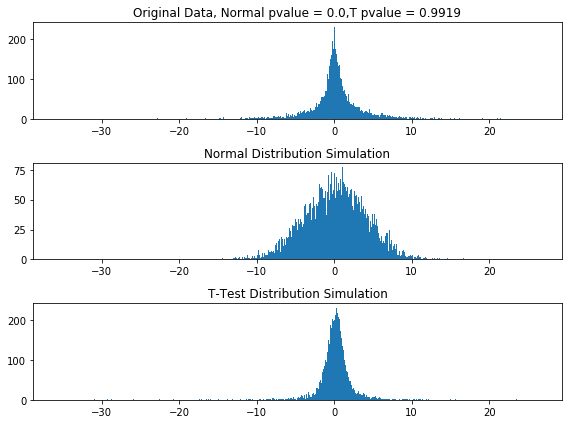

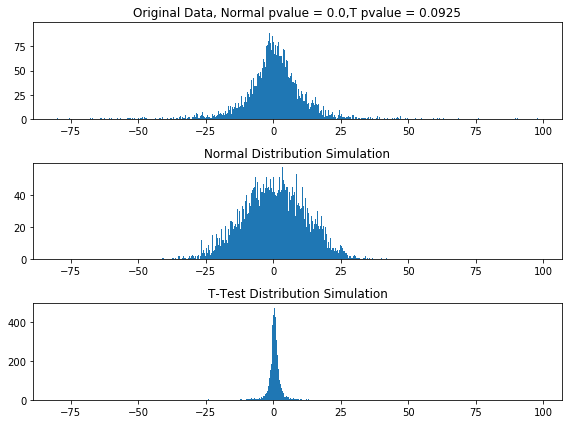

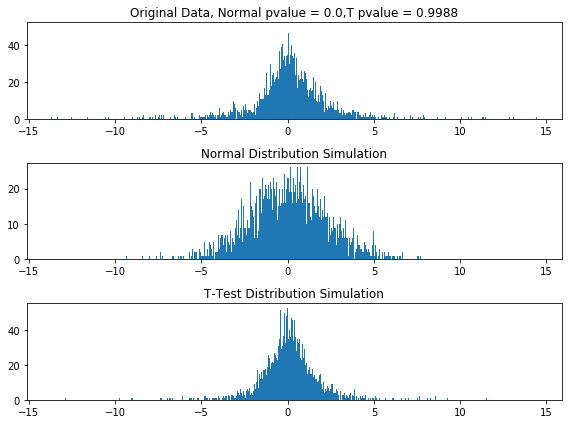

[None, None, None]

In [9]:
list(map(show_returns_hist, (df_apple_returns, df_google_returns, df_fb_returns)))

Получаем, что ни в одном случае нормальным распределением исходное не приближается ни по картинке, ни по p-value. Для 1 и 3 картинки, однако, хорошо подходит t-распределение: и по картинке, и по p-value. Для второй картинки распределение плохо приближается t-распределением. Возможно, это связано с тем, что у гугла две разных акции, GOOGL и GOOG, и из-за этого распределение ведёт себя не так, как остальные два.

In [10]:
for df in (df_apple_returns, df_google_returns, df_fb_returns):
    print(f'pvalue теста стационарности: {adfuller(df)[1]}')

pvalue теста стационарности: 0.0
pvalue теста стационарности: 0.0
pvalue теста стационарности: 3.579357849918425e-18


Значит, на разумном уровне значимости можно заключить, что все три временных ряда не стационарны.